# Deep Learning & Geophysical Dynamics
## Project - cloud cover nowcasting

In this notebook, a deep learning project is proposed based on the open source weather dataset from Météo France : MétéoNet. 
https://meteonet.umr-cnrm.fr/

The dataset comprises 3 years of weather data with different data sources : 
- Ground stations observations
- 2D and 3D Numercial Weather Predictions (AROME, ARPEGE)
- Rain radar data
- Satellite date : optical, infrared, cloud type

In this project we will focus on the nowcasting of cloud cover. Less covered in the litterature than the rainfall nowcasting, cloud cover nowcasting is of great interest for the solar power short term production forecasting and for the satellites line of sight forecasting. 

This project will be based on Satellite data, wind data and rain radar data. The goal will be to predict a sequence of cloud cover images from past images and exogeneous variables. 



## 1. Read Cloud Type data

In [55]:
import xarray as xr
import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [56]:
path0 = "./DL_GS_Project_CloudNowcasting"
area = 'SE'
year = '2016'
fname = path0 + "/CT/CT_%s_%s.nc" % (area,year)
data = xr.open_dataset(fname, engine = 'netcdf4')
display(data)

<xarray.Dataset>
Dimensions:  (time: 34880, lat: 171, lon: 261)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:45:00
  * lat      (lat) float64 46.25 46.22 46.19 46.16 ... 41.19 41.16 41.13 41.1
  * lon      (lon) float64 2.0 2.03 2.06 2.09 2.121 ... 9.752 9.782 9.812 9.842
Data variables:
    CT       (time, lat, lon) uint8 ...
Attributes:
    creating_function:   create_nc_file
    appending_function:  append_unlimited_dim_nc_file

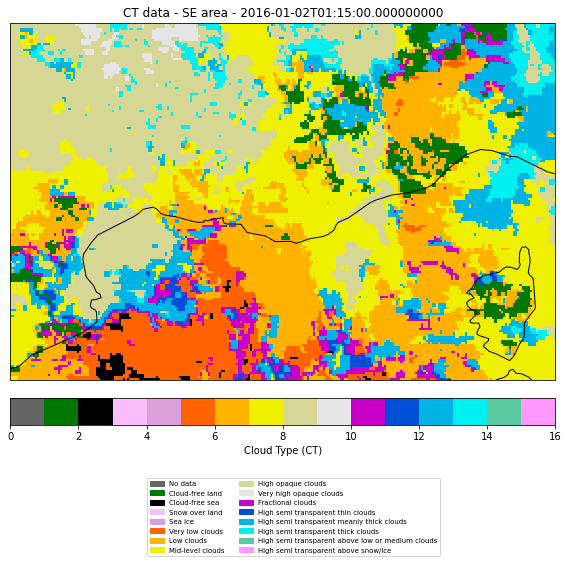

In [57]:
nbClasses = 16
CLOUD_TYPE_16 = {
    "0":"No data",
    "1":"Cloud-free land",
    "2":"Cloud-free sea",
    "3":"Snow over land",
    "4": "Sea ice",
    "5":"Very low clouds",
    "6":"Low clouds",
    "7":"Mid-level clouds",
    "8":"High opaque clouds",
    "9":"Very high opaque clouds",
    "10":"Fractional clouds",
    "11":"High semi transparent thin clouds",
    "12":"High semi transparent meanly thick clouds",
    "13":"High semi transparent thick clouds",
    "14":"High semi transparent above low or medium clouds",
    "15":"High semi transparent above snow/ice"
}
CT_16_COLOR_MAP = [[0.39215686, 0.39215686, 0.39215686],
                   [0., 0.47058824, 0.],
                   [0., 0., 0.],
                   [0.98039216, 0.74509804, 0.98039216],
                   [0.8627451, 0.62745098, 0.8627451],
                   [1., 0.39215686, 0.],
                   [1., 0.70588235, 0.],
                   [0.94117647, 0.94117647, 0.],
                   [0.84313725, 0.84313725, 0.58823529],
                   [0.90196078, 0.90196078, 0.90196078],
                   [0.78431373, 0., 0.78431373],
                   [0., 0.31372549, 0.84313725],
                   [0., 0.70588235, 0.90196078],
                   [0., 0.94117647, 0.94117647],
                   [0.35294118, 0.78431373, 0.62745098],
                   [1, 0.6, 1]]
color = CT_16_COLOR_MAP
legend = CLOUD_TYPE_16
cmap = colors.ListedColormap(color)
norm = colors.BoundaryNorm([i for i in range(nbClasses+1)], cmap.N)
patches = [mpatches.Patch(color=color[i], label=legend[str(i)]) for i in range(nbClasses)]
# data.isel(time=[0,3,5,7])['CT'].plot(x='lon', y='lat',col='time',cmap=cmap, norm=norm)
# plt.show()

date = data['time'].values[100]
minlat = data['lat'].min()
maxlat = data['lat'].max()
minlon = data['lon'].min()
maxlon = data['lon'].max()
extent = [minlon, maxlon, minlat, maxlat]
fig = plt.figure(figsize=(8,9))
ax = plt.axes(projection=ccrs.PlateCarree())
img = plt.imshow(data.sel(time=date)['CT'], interpolation='none', origin='upper',cmap=cmap, norm=norm, extent=extent)
ax.coastlines(resolution='50m', linewidth=1)
ax.set_extent(extent)
plt.colorbar(img, orientation= 'horizontal', pad=0.03).set_label('Cloud Type (CT)')
plt.legend(handles=patches, loc='lower center',ncol=2,bbox_to_anchor=(0.12, -0.5, 0.8, 0.4),fontsize = 'x-small')
plt.title('CT data - '+ area + ' area - '+ str(date))
plt.tight_layout()

## Binary Cloud data prediction

The initial task will consist in predicting the positions of cloud, thus we're going to change the dataset into a binary dataset of cloud position. 0 will describe a pixel with no cloud and 1 a pixel with a cloud. The model should then predict the probability of having a cloud in one pixel. 

In [58]:
fname = path0 + "CT/CT_%s_2017.nc" % (area)
data_train = xr.concat([data, xr.open_dataset(fname, engine = 'netcdf4')], 'time')
fname = path0 + "CT/CT_%s_2018.nc" % (area)
data_test = xr.open_dataset(fname, engine = 'netcdf4')


In [59]:
data_train = data_train.assign(binary_cloud = (data_train["CT"] > 5)*1)
data_test = data_test.assign(binary_cloud = (data_test["CT"] > 5)*1)
display(data_train)

<xarray.Dataset>
Dimensions:       (time: 69264, lat: 171, lon: 261)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-01 ... 2017-12-31T23:45:00
  * lat           (lat) float64 46.25 46.22 46.19 46.16 ... 41.16 41.13 41.1
  * lon           (lon) float64 2.0 2.03 2.06 2.09 ... 9.752 9.782 9.812 9.842
Data variables:
    CT            (time, lat, lon) uint8 
    binary_cloud  (time, lat, lon) int32 
Attributes:
    creating_function:   create_nc_file
    appending_function:  append_unlimited_dim_nc_file

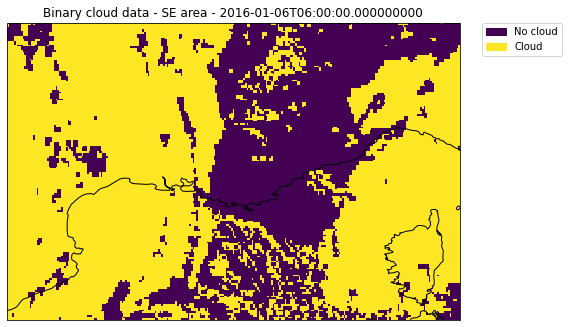

In [60]:

date = data_train['time'].values[500]
minlat = data_train['lat'].min()
maxlat = data_train['lat'].max()
minlon = data_train['lon'].min()
maxlon = data_train['lon'].max()
extent = [minlon, maxlon, minlat, maxlat]
fig = plt.figure(figsize=(8,9))
ax = plt.axes(projection=ccrs.PlateCarree())
img = plt.imshow(data_train.sel(time=date)['binary_cloud'], interpolation='none', origin='upper', extent=extent)
ax.coastlines(resolution='10m', linewidth=1)
ax.set_extent(extent)

values = [0, 1]
labels = ['No cloud', 'Cloud']
colors = [ img.cmap(img.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label= labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.title('Binary cloud data - '+ area + ' area - '+ str(date))
plt.tight_layout()

# Task description

From a sequence of 6 past cloud images (1h30), we will try to forecast the next hour of cloud cover (4 images). You can use the method described in the preprint of Berthomier et. al. 

Score the forecast versus the persistence (and/or the translation of clouds along the wind forecast ?). Try to interpret the forecast in terms of cloud translation, cloud creation, shape. 

Feel free to add other MeteoNet data (rainfall data (radar every 5min), NWP data, satellite visible data)